# AAI 511 Final Team Project

Group 2

Members: Daniel Shifrin, Jory Hamilton, Alden Caterio

# Introduction

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.




# Objective

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# mido is a python library to works with MIDI files/data (music in this project)
! pip install mido

In [3]:
import pandas as pd
import os
import librosa
import numpy as np
import mido
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, TimeDistributed, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

tf.config.run_functions_eagerly(True)
warnings.filterwarnings(action='ignore')

# Data Collection

The project will use a dataset consisting of musical scores from various composers. The dataset will contain MIDI files and sheet music of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. The dataset should be labeled with the name of the composer for each score.

The datast was obtained from Kaggle at the following link.
https://www.kaggle.com/datasets/blanderbuss/midi-classic-music

In [4]:
# get directory of dataset
data_dir = '/content/drive/MyDrive/ColabNotebooks/AAI511/FinalProject/Composer_Dataset'
initial_filelist = os.listdir(data_dir)
initial_filelist

['Tchaicovsky Waltz of the Flowers.MID',
 'Tchaikovsky Lake Of The Swans Act 1 1mov.mid',
 'Tchaikovsky Lake Of The Swans Act 2 14mov.mid',
 'Tchaikovsky Lake Of The Swans Act 2 13mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 7-8movs.mid',
 'Rothchlid Symphony Rmw12 3mov.mid',
 'Tchaikovsky Lake Of The Swans Act 2 10mov.mid',
 'Tchaikovsky Lake Of The Swans Act 2 12mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 2mov.mid',
 'Sibelius Kuolema Vals op44.mid',
 'Tchaikovsky Lake Of The Swans Act 1 4mov.mid',
 'Wagner Ride of the valkyries.mid',
 'Tchaikovsky Lake Of The Swans Act 1 9mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 5mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 6mov.mid',
 'Tchaikovsky Lake Of The Swans Act 2 11mov.mid',
 'Rothchild Symphony Rmw12 2mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 3mov.mid',
 'midiclassics.zip',
 'Arensky',
 'Alkan',
 'midiclassics',
 'Albe╠üniz',
 'Ambroise',
 'Arndt']

In [5]:
# composer folders containing midi files are in 'midiclassics' folder
filelist = os.listdir(data_dir + '/midiclassics')
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
for name in composers:
  if name in filelist:
    print(f"{name} is found in the directory")

Bach is found in the directory
Beethoven is found in the directory
Chopin is found in the directory
Mozart is found in the directory


In [6]:
# map songs to composers
# 0 = bach, 1 = beethoven, 2 = chopin, 3 = mozart
data_dir_new = data_dir + '/midiclassics'
midi_file = []
composer_key = []
for i in range(len(composers)):
  print(f"Getting files for {composers[i]}")
  filenames = os.listdir(data_dir_new + '/' + composers[i])
  for filename in filenames:
    if '.mid' in filename:
      midi_file.append(filename)
      composer_key.append(i)

Getting files for Bach
Getting files for Beethoven
Getting files for Chopin
Getting files for Mozart


In [7]:
# Create array with all files and accompanying composer key
files_keys = np.array(list(zip(midi_file,composer_key)))

# Create dataframe to map composers to songs
df = pd.DataFrame(files_keys, columns = ['Song', 'Composer Key'])

# Print shape and preview
print(f"Shape of df = {np.shape(df)}")
df.head()

Shape of df = (481, 2)


,Song,Composer Key
0,AveMaria.mid,0
1,Bwv0533 Prelude and Fugue.mid,0
2,Bwv0532 Toccata and Fugue.mid,0
3,Bwv0531 Prelude and Fugue.mid,0
4,Bwv0530 Sonate en trio n6.mid,0


In [8]:
# Create list of datapaths
datapaths = []
for i in range(len(df)):
  temp_str = data_dir_new + '/' + composers[int(df['Composer Key'].loc[i])] + '/' + df['Song'].iloc[i]
  datapaths.append(temp_str)

# Print datapath previews
datapaths[0:5]

['/content/drive/MyDrive/ColabNotebooks/AAI511/FinalProject/Composer_Dataset/midiclassics/Bach/AveMaria.mid',
 '/content/drive/MyDrive/ColabNotebooks/AAI511/FinalProject/Composer_Dataset/midiclassics/Bach/Bwv0533 Prelude and Fugue.mid',
 '/content/drive/MyDrive/ColabNotebooks/AAI511/FinalProject/Composer_Dataset/midiclassics/Bach/Bwv0532 Toccata and Fugue.mid',
 '/content/drive/MyDrive/ColabNotebooks/AAI511/FinalProject/Composer_Dataset/midiclassics/Bach/Bwv0531 Prelude and Fugue.mid',
 '/content/drive/MyDrive/ColabNotebooks/AAI511/FinalProject/Composer_Dataset/midiclassics/Bach/Bwv0530 Sonate en trio n6.mid']

# Data Pre-Processing and Feature Extraction

Each midi file contains musical data in the form of numerical data. For example, all the notes in each file are quantified and represented by a number, and those numbers form a pattern which can be used to train a neural network.

In our project, we will be using Mido, a Python library for working with midi messages. Using Mido, we can extract the notes data from each file and format it to be suitable for training the LSTM and CNN.

https://mido.readthedocs.io/en/stable/#

In [9]:
def get_notes_from_midi(datapath):
  """
  Get the notes from a Midi file
  """
  notes_from_midi = []
  try:
    midifile = mido.MidiFile(datapath, clip=True)
    for msg in midifile:
      if msg.type == 'note_on' and msg.velocity > 0:
        notes_from_midi.append((msg.time, msg.note, msg.velocity))
  except:
    notes_from_midi = np.zeros((1,3))

  return notes_from_midi

In [10]:
# Find the average length of the midi file note sequences
notes_arr = []
avg_len = []
for path_i in range(len(datapaths)):
  temp_notes_arr = get_notes_from_midi(datapaths[path_i])
  avg_len.append(len(temp_notes_arr))

notes_arr_avg = int(np.mean(avg_len))

In [11]:
print(f"Average length of midi file note sequences = {notes_arr_avg}")

# this number will be used for the padding

Average length of midi file note sequences = 3501


In [12]:
def pad_sequence(note_sequence, maxlen):
  """
  Pad/trim the note sequence to a fixed length (maxlen).
  """
  padded_sequence = np.zeros((maxlen, 3))
  sequence_length = min(len(note_sequence), maxlen)
  padded_sequence[:sequence_length] = note_sequence[:sequence_length]

  return padded_sequence

In [13]:
# Initialize variables
midi_notes = []
rowstodrop = []
print_flag = 1;
key_match = 0;

# iterate through all datapaths
for path_i in range(len(datapaths)):
  # Print what composer's music is being processed
  current_composer = int(df['Composer Key'].iloc[path_i])
  if current_composer == key_match:
    print_flag = 1
    key_match = key_match+1
  if print_flag == 1:
    print(f"Getting midi files for {composers[current_composer]}")
    print_flag = 0

  # Read midi file
  notes_arr = get_notes_from_midi(datapaths[path_i])

  # Pad the file
  notes_arr_padded = pad_sequence(notes_arr, notes_arr_avg)

  # If file is completely empty (all values are zeros),
  # do not add to midi_notes list
  if not np.any(notes_arr_padded):
    # need to drop the row on df to keep it the same length as the midi_notes list
    rowstodrop.append(path_i)
    continue

  # Append to midi list
  midi_notes.append(notes_arr_padded)

# Drop rows of the invalid data to keep dimensions the same as the midi list
df_new = df.drop(rowstodrop)

# Checking if shape is consistent
print(f"""
Shape of midi data = {np.shape(midi_notes)}
Shape of df_new = {np.shape(df_new)}
      """)

Getting midi files for Bach
Getting midi files for Beethoven
Getting midi files for Chopin
Getting midi files for Mozart

Shape of midi data = (480, 3501, 3)
Shape of df_new = (480, 2)
      


Data used to train a CNN is typically image data with a specific height and width. Since we have tabular data, we have to convert it into something resembling an image. Reshaping the data will involve resizing the data to a 1D array, then downsizing it to a 2D array with dimensions that are similar to an image. This needs to be done for each datapoint.

In [14]:
# Data for CNN should be similar to image data
# First, we need to resize the data

# Trim the data to a specific length
trim_to_len = 3200
midi_notes_new = []
for resize_i in range(len(midi_notes)):
  trimmed_notes = midi_notes[resize_i][0:trim_to_len]
  midi_notes_new.append(trimmed_notes)

print(f"New shape of input data = {np.shape(midi_notes_new)}")

New shape of input data = (480, 3200, 3)


After trimming the data to a more clean length (3200), we will convert one datapoint to a 1D array to test out the dimensions.

In [15]:
# Reshape data of one datapoint into 1D array
datashape_new = np.shape(midi_notes_new)
data_1D = np.reshape(midi_notes_new[0], datashape_new[1]*datashape_new[2])

print(f"Shape of 1D array = {np.shape(data_1D)}")

Shape of 1D array = (9600,)


The length of the 1D array is 9600. This can be converted cleanly into an array of size (80, 120). So each datapoint will be converted accordingly.

In [16]:
# Define x and y dimensions
dim_x = 80
dim_y = 120

# Iterate through every datapoint, reshaping the data to (80, 120)
midi_notes_reshaped = []
for reshape_i in range(len(midi_notes_new)):
  data_1D = np.reshape(midi_notes_new[reshape_i], datashape_new[1]*datashape_new[2])
  data_reshaped = np.reshape(data_1D, (dim_x, dim_y))
  midi_notes_reshaped.append(data_reshaped)
shape_CNN_data = np.shape(midi_notes_reshaped)
print(f"New shape of input data = {shape_CNN_data}")

New shape of input data = (480, 80, 120)


# Model Building

## Long Short-Term Memory (LSTM)

The LSTM model is designed to handle the sequential nature of music, making it well-suited for capturing the temporal dependencies between notes and chords. The model architecture includes multiple LSTM layers, followed by dense layers, to learn both short-term and long-term patterns within the musical data.

In [17]:
def build_lstm_model(input_shape, num_classes):
    """
      Define the LSTM model
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# Define input shapes for LSTM
input_shape = (notes_arr_avg, 3)  # (sequence_length, feature_dim)
num_classes = 4  # Number of composers

# Build the model
model_LSTM = build_lstm_model(input_shape, num_classes)

# Output summary
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3501, 128)           │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3501, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,196 (844.52 KB)

 Trainable params: 216,196 (844.52 KB)

 Non-trainable params: 0 (0.00 B)

## Convolutional Neural Network (CNN)

The CNN model is employed to extract hierarchical features from the musical scores. By applying convolutional layers to the input data, the model can identify local patterns such as recurring motifs or harmonic structures. The architecture includes several convolutional and pooling layers, followed by fully connected layers to classify the compositions.

In [19]:
def build_cnn_model(input_shape, num_classes):
    """
      Define the CNN model
    """
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
# Define input shape for CNN
input_shape = (shape_CNN_data[1], shape_CNN_data[2], 1)

# Build the model
model_CNN = build_cnn_model(input_shape, num_classes)

# Output model summary
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 118, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 39, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,128,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,148,228 (15.82 MB)

 Trainable params: 4,148,228 (15.82 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

Now we will train each model, starting with the LSTM model

## LSTM Training

In [21]:
# Define X and y
# X = independent variables
# y = dependent variable
X = np.array(midi_notes)
y = np.array(df_new['Composer Key'])  # Convert composer names to numeric labels

In [22]:
np.shape(X)

(480, 3501, 3)

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# convert to one-hot encoding for training only
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

In [25]:
# Display shape of data
print(f"""
    shape of X = {np.shape(X_train)}
    shape of y = {np.shape(y_train_encoded)}
      """)


    shape of X = (384, 3501, 3)
    shape of y = (384, 4)
      


In [26]:
# Train the LSTM model
history_LSTM = model_LSTM.fit(X_train, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test, y_test_encoded))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.2736 - loss: 1.3675 - val_accuracy: 0.3021 - val_loss: 1.3779
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.3773 - loss: 1.3200 - val_accuracy: 0.3125 - val_loss: 1.4009
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.3427 - loss: 1.3297 - val_accuracy: 0.3125 - val_loss: 1.3749
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.3871 - loss: 1.2762 - val_accuracy: 0.3125 - val_loss: 1.3776
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.3990 - loss: 1.2884 - val_accuracy: 0.3229 - val_loss: 1.3852
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.3746 - loss: 1.2873 - val_accuracy: 0.3125 - val_loss: 1.3867
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.3987 - loss: 1.2853 - val_accuracy: 0.3021 - val_loss: 1.3751
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.3683 - loss: 1.2825 - val_accuracy: 0.3021 - val_loss:

## CNN Training



In [27]:
# Define X
X = np.array(midi_notes_reshaped)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Reshape data for CNN
datashape = np.shape(midi_notes_reshaped)
X_train = X_train.reshape((X_train.shape[0], datashape[1], datashape[2], 1))
X_test = X_test.reshape((X_test.shape[0], datashape[1], datashape[2], 1))

# Normalize the data
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# convert to one-hot encoding for training only
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

In [29]:
# Preview of the shape of the training (and test) data
X_train.shape

(384, 80, 120, 1)

In [30]:
# Train the CNN model
history_CNN = model_CNN.fit(X_train, y_train_encoded, epochs=50, batch_size=64,validation_data=(X_test, y_test_encoded))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.3330 - loss: 3.6916 - val_accuracy: 0.3333 - val_loss: 1.3771
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3694 - loss: 1.3740 - val_accuracy: 0.3542 - val_loss: 1.3814
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4359 - loss: 1.2597 - val_accuracy: 0.4167 - val_loss: 1.3358
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4879 - loss: 1.1598 - val_accuracy: 0.5000 - val_loss: 1.1902
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5403 - loss: 1.0672 - val_accuracy: 0.4792 - val_loss: 1.1525
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6202 - loss: 0.9305 - val_accuracy: 0.5000 - val_loss: 1.1097
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7014 - loss: 0.7915 - val_accuracy: 0.5521 - val_loss: 1.1260
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7046 - loss: 0.7222 - val_accuracy: 0.5729 - val_loss: 1.204

# Model Evaluation

After training the models, we can proceed with evaluating their performance by checking several metrics. Accuracy, precision, recall, and F1 score will be examined. Also, the training history will be plotted.



In [31]:
def plot_training_history(model_name, model_history):
  """
  Generate plot of training history
  """
  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['loss'], label='loss')
  plt.plot(model_history.history['val_loss'], label='val loss')
  plt.ylabel('MSE')
  plt.xlabel('Number of epochs')
  plt.legend(loc="upper right")
  plt.title(f"{model_name} Training History")
  plt.show()

In [32]:
def evaluate_model(model, X_test, y_test):
    """
    Generate evaluation metrics for the given model
    """
    predictions = model.predict(X_test)
    predictions_key = []
    for results in predictions:
      predictions_key.append(str(np.argmax(results)))

    accuracy = accuracy_score(y_test, predictions_key)
    precision = precision_score(y_test, predictions_key, average='weighted')
    recall = recall_score(y_test, predictions_key, average='weighted')
    f1 = f1_score(y_test, predictions_key, average='weighted')

    print("\nEvaluation Metrics\n")
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

## LSTM Evaluation

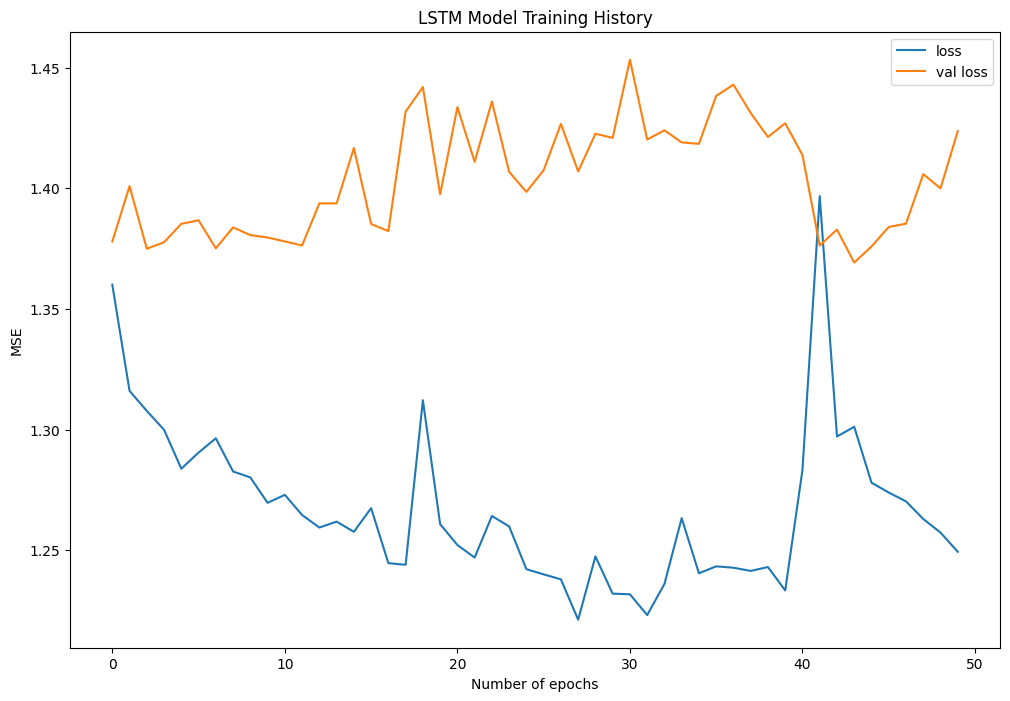

In [33]:
plot_training_history('LSTM Model', history_LSTM)

In [34]:
evaluate_model(model_LSTM, X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Evaluation Metrics

Accuracy: 28.12%
Precision: 24.53%
Recall: 28.12%
F1 Score: 20.86%


## CNN Evaluation

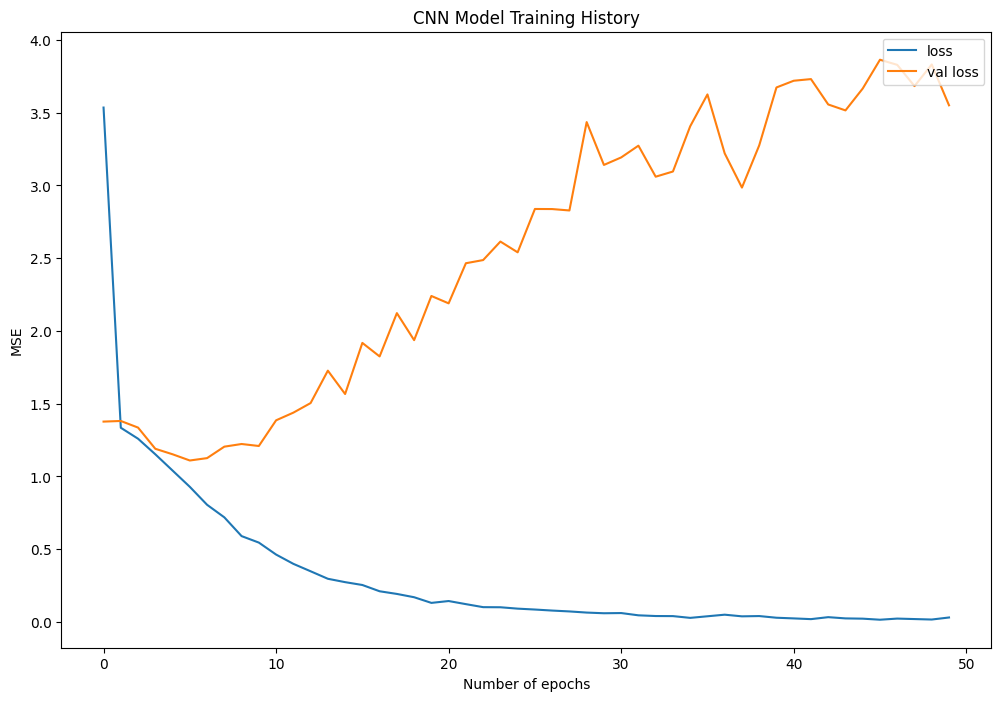

In [35]:
plot_training_history('CNN Model', history_CNN)

In [36]:
evaluate_model(model_CNN, X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation Metrics

Accuracy: 52.08%
Precision: 56.18%
Recall: 52.08%
F1 Score: 52.39%
